In [1]:
using Random, Statistics, PyPlot

In [2]:
struct Point2D
    x::Int64
    y::Int64
end

struct SquareLattice
    Nx::Int64
    Ny::Int64    
end

import Base.length
function length(lat::SquareLattice)
    return lat.Nx*lat.Ny
end

function PointToIndex(lat::SquareLattice, r::Point2D)
    @assert r.x <= lat.Nx "Site x coordinate exceeding lattice length"
    @assert r.y <= lat.Ny "Site y coordinate exceeding lattice width"
    
    return (r.y-1)*lat.Nx + r.x
end

function IndexToPoint(lat::SquareLattice, ind::Int64)
    
    @assert ind <= length(lat) "Site index exceeding lattice size"
    
    y = div(ind-1, lat.Nx)+1
    x = mod(ind-1, lat.Nx)+1

    return Point2D(x,y)
end
    
function NearestNeighbors(lat::SquareLattice, ind::Int64)

    r = IndexToPoint(lat, ind)
    
    nn = zeros(Int64,4)
    
    xp = mod(r.x, lat.Nx)+1
    yp = mod(r.y, lat.Ny)+1
    xm = mod(r.x-2, lat.Nx)+1
    ym = mod(r.y-2, lat.Ny)+1
    
    nn[1] = PointToIndex(lat, Point2D(xm, r.y) )
    nn[2] = PointToIndex(lat, Point2D(xp, r.y) )
    nn[3] = PointToIndex(lat, Point2D(r.x, ym) )
    nn[4] = PointToIndex(lat, Point2D(r.x, yp) )
    
    return nn
end

NearestNeighbors (generic function with 1 method)

In [41]:
lat = SquareLattice(10,10)
nn = NearestNeighbors(lat, PointToIndex(lat, Point2D(1,10)))
#nn = NearestNeighbors(lat, PointToIndex(lat, Point2D(2,3)))
for r in nn
    @show IndexToPoint(lat, r)
end

IndexToPoint(lat, r) = Point2D(10, 10)
IndexToPoint(lat, r) = Point2D(2, 10)
IndexToPoint(lat, r) = Point2D(1, 9)
IndexToPoint(lat, r) = Point2D(1, 1)


In [5]:
function IsingConfigurationEnergy(lat::SquareLattice, c::Vector{Int64})
    
    N = length(lat)
    @assert N == length(c) "Configuration incompatible with lattice size"
    
    Ec = 0.
    
    for j in range(1, length = N)
        nn = NearestNeighbors(lat, j)
        Ec += -4*(c[j]-1/2)*sum(c[nn].-1/2)
    end
    return Ec/2 # in the summation above every bond is included twice
end

IsingConfigurationEnergy (generic function with 1 method)

In [7]:
function IsingMonteCarloSweep!(lat::SquareLattice, c::Vector{Int64}, T::Float64)

    N = length(lat)
    
    @assert N == length(c) "Configuration incompatible with lattice size"
    
    dE = 0. # total energy change after a sweep
    
    for j in range(1, length = N)
        
        ind = rand(1:N) # pick a random site
        
        nn = NearestNeighbors(lat, ind)        

        dEj = 2*4*(c[ind]-1/2) *sum(c[nn].-1/2) # energy difference upon flipping the spin
        r = exp(-dEj/T) # ratio of Boltzmann weights W(si_flipped)/W(si)
        
        if r > rand()
            c[ind] = 1-c[ind] # accept the move and update the configuration
            dE += dEj
        end    
    end
    
    return dE
end

IsingMonteCarloSweep! (generic function with 1 method)

In [8]:
function IsingMC(lat::SquareLattice, T::Float64, Nsw::Int64, saveConfigs = false)
    # Nsw is the number of sweeps to perform
    
    c = rand(0:1, length(lat))

    if saveConfigs
        configs = zeros(Int64, Nsw, length(lat))
        configs[1, :] = c
    end
    
    m = zeros(Float64, Nsw) # absolute value of the magnetization per site
    m[1] = abs( mean(2*c .- 1) )
    
    En = zeros(Float64, Nsw)
    En[1] = IsingConfigurationEnergy(lat, c)
    
    for i in range(2, stop=Nsw)
        
        dEi = IsingMonteCarloSweep!(lat, c, T)
        En[i] = En[i-1] + dEi
        
        if saveConfigs
            configs[i, :] = c
        end

        m[i] =  abs( mean(2*c .- 1) )

    end
    
    if saveConfigs
        return m,En,c
    else
        return m,En
    end
    
end

IsingMC (generic function with 2 methods)

In [54]:
lat = SquareLattice(10,10)
T = 2.
Nsw = 1000
m,En = IsingMC(lat, T, Nsw);

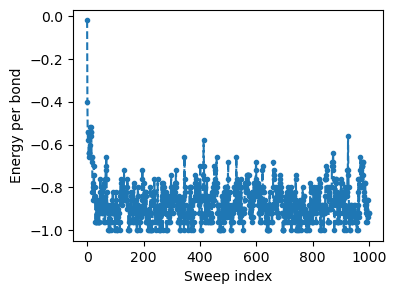

In [55]:
figure(figsize=(4,3))
plot(En/length(lat)/2, "--.") # energy per bond
xlabel("Sweep index")
ylabel("Energy per bond");

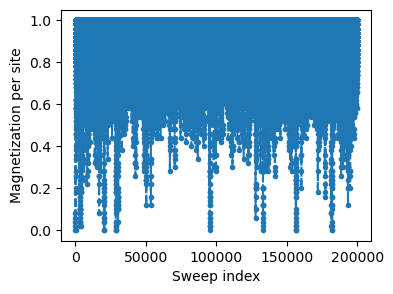

In [56]:
Neq = 1000
Nsw = Neq*200
m,En = IsingMC(lat, T, Nsw);

figure(figsize=(4,3))
plot(m, "--.") # magnetization per site
xlabel("Sweep index")
ylabel("Magnetization per site");

In [28]:
function CalculateError(m, Neq, Nsw)
    err = Float64[]
    Nsw2 = 2^Int(floor(log(2, Nsw-Neq))) # closest power of 2 smaller than number of sweeps after equilibration
    ml = m[end-Nsw2+1:end]
    min_size = 2^5
    while length(ml) > min_size
        push!(err, std(ml)/sqrt(length(ml)-1))
        ml = map(j -> mean(ml[2*j-1:2*j]), range(1,stop=div(length(ml),2)) )
    end
    return err
end

CalculateError (generic function with 1 method)

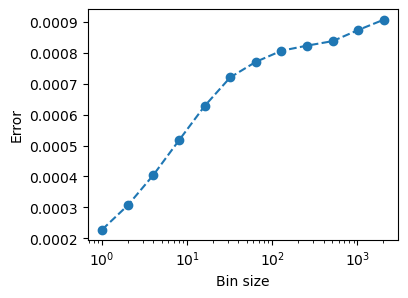

In [57]:
err = CalculateError(m, Neq, Nsw)
figure(figsize=(4,3))
plot(2 .^ range(0, length= length(err)), err, "--o")
ylabel("Error")
xlabel("Bin size")
xscale("log")

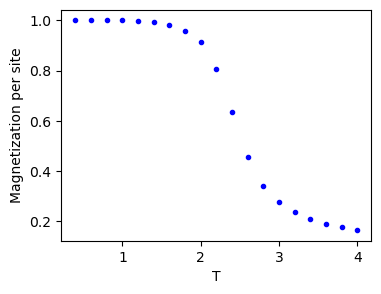

In [14]:
figure(figsize=(4,3))
lat = SquareLattice(10,10)
Neq = 10000
Ntot = 200000
tau = Float64[]
for T in range(0.4, stop=4., step=0.2)
    m, En = IsingMC(lat, T, Ntot);
    err = CalculateError(m, Neq, Ntot)
    errorbar(T, mean(m[Neq:end]), err[end], c="blue", marker=".")
    push!(tau, ((err[end]/err[1])^2-1)/2)
end
xlabel("T")
ylabel("Magnetization per site");

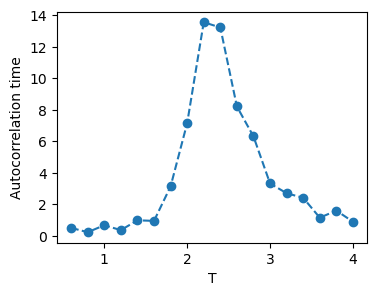

In [15]:
figure(figsize=(4,3))
plot(range(0.4, stop=4., step=0.2), tau, "--o")
xlabel("T")
ylabel("Autocorrelation time");